# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.utils import resample

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Import Data

In [2]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_15_20.csv', encoding='latin-1')
raw_df = raw_df.dropna(how='all')

In [3]:
# Review the first few rows of the data set
raw_df.head()

,Document,Sentence,Trigger,Multiclass,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Check size of the data set
raw_df.shape

(2618, 24)

In [5]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [6]:
# Check for null values
raw_df.isnull().sum()

Document      0
Sentence      0
Trigger       0
Multiclass    0
dtype: int64

In [7]:
raw_df.dropna()
raw_df.shape

(2618, 4)

In [8]:
raw_df.head(11)

,Document,Sentence,Trigger,Multiclass
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",Loan Default,0.0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Aggregate DSCR Fall,1.0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,Loan Default,1.0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,Loan Default,0.0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,Loan Default,0.0
5,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,Loan Default,0.0
6,20120828_01Y0R8_Prospectus_CM00000000205875087...,So long as no Trigger Period or Event of Defau...,Loan Default,0.0
7,20120828_01Y0R8_Prospectus_CM00000000205875087...,During the continuance of a Trigger Period or ...,Loan Default,0.0
8,20120828_01Y0R8_Prospectus_CM00000000205875087...,ÒTrigger PeriodÓ means any period that the deb...,DSCR Fall,0.0
9,20120828_01Y0R8_Prospectus_CM00000000205875087...,"During the continuance of a Trigger Period, th...",Loan Default,0.0


## Data Cleaning

In [9]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

nontrigger                   1056
Unspecified                   496
Loan Default                  468
Debt Yield Fall               168
Loan default                   75
Tenant Failure                 74
Mezzanine Default              63
Bankruptcy                     47
Debt yield fall                34
DSCR Fall                      24
Renovations                    24
Operator Termination           19
Sponsor Termination            14
Aggregate Debt Yield Fall      12
Mezzanine Outstanding          10
SFF                             9
Mezzanine default               8
Aggregate DSCR Fall             8
Aggregate debt yield fall       6
Delayed Repayment               3
Name: Trigger, dtype: int64

In [10]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [11]:
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')

In [12]:
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [13]:
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [14]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  543
Unspecified                   496
Debt Yield Fall               202
Tenant Failure                 74
Mezzanine Default              71
Bankruptcy                     47
Renovations                    24
Dscr Fall                      24
Operator Termination           19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

In [15]:
# Rename first column (document title)
# raw_df = raw_df.rename(columns = {'0': 'Document'})

In [16]:
# Drop Multiclass column for now 
raw_df = raw_df.drop('Multiclass', axis = 1)


In [17]:
raw_df.shape

(2618, 3)

In [18]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

35 unique documents have been included in the data set


In [19]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf     176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf     138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf     135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf     125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf     118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf     114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf     112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf     111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf     109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf      99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf      84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf      82
20170814_02E227_Prospectus_SD000000002367167139.pdf      82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf      76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf      75
20170525_02DFUI_Prospectus_SD00000000235

In [20]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

The 35 Documents have tag counts that range from 25 to 176.


In [21]:
# Check for duplicate rows
# raw_df['is_duplicate'] = raw_df.duplicated(subset = None)
# raw_df['is_duplicate'].value_counts()

In [22]:
# num_duplicated_rows = (raw_df['is_duplicate'] == True).sum()
# print(f'There are {num_duplicated_rows} row duplicates in the data set.')

In [23]:
# This removes duplicate rows, but those rows are in fact legitimate in the document
# raw_df = raw_df.drop('is_duplicate', axis = 1)
# raw_df = raw_df.drop_duplicates()

In [24]:
# raw_df.shape

In [25]:
# raw_df.head()

In [26]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

Nontrigger                   1056
Loan Default                  543
Unspecified                   496
Debt Yield Fall               202
Tenant Failure                 74
Mezzanine Default              71
Bankruptcy                     47
Renovations                    24
Dscr Fall                      24
Operator Termination           19
Aggregate Debt Yield Fall      18
Sponsor Termination            14
Mezzanine Outstanding          10
Sff                             9
Aggregate Dscr Fall             8
Delayed Repayment               3
Name: Trigger, dtype: int64

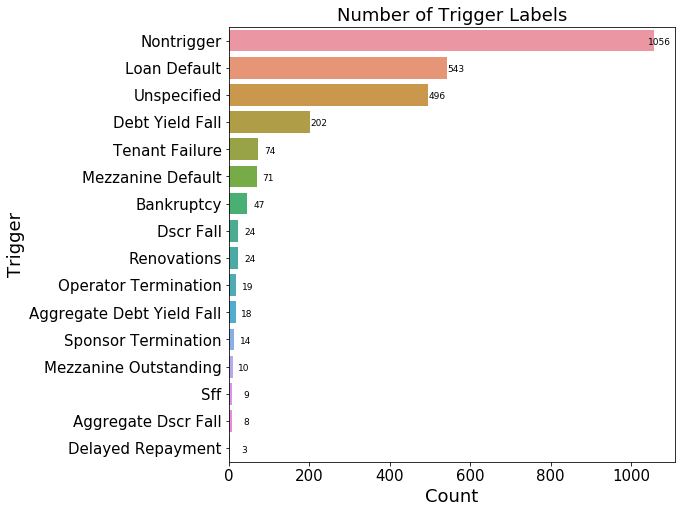

In [27]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Labels', fontsize = 18)

plt.xlabel('Count', fontsize = 18)
plt.ylabel('Trigger', fontsize = 18)
plt.tick_params(labelsize=15)

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [28]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

20181231_02IEP9_Prospectus_SD000000002568455603.pdf     176
20190220_02IPLU_Prospectus_SD000000002587491183.pdf     138
20190220_02IUQ7_Prospectus_SD000000002587520085.pdf     135
20160510_02B0XU_Prospectus_SD000000002312723382.pdf     125
20190108_02IFF1_Prospectus_SD000000002570458466.pdf     118
20190131_02IFCW_Prospectus_SD000000002578232050.pdf     114
20190131_02IFDN_Prospectus_SD000000002578234912.pdf     112
20190131_02IFE7_Prospectus_SD000000002578234792.pdf     111
20190208_02IM7M_Prospectus_SD000000002581684036.pdf     109
20190220_02IUQG_Prospectus_SD000000002587491537.pdf     100
20190205_02IJ77_Prospectus_SD000000002579874729.pdf      99
20170616_02DNAM_Prospectus_SD000000002355931744.pdf      84
20180125_02FE6L_Prospectus_SD000000002394837596.pdf      82
20170814_02E227_Prospectus_SD000000002367167139.pdf      82
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf      76
20170727_02DTVX_Prospectus_SD000000002362015714.pdf      75
20170525_02DFUI_Prospectus_SD00000000235

In [29]:
raw_df.dtypes

Document    object
Sentence    object
Trigger     object
dtype: object

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [30]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']
    
    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)
    
    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')
        
        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])
        reshaped = reshaped.drop_duplicates().reset_index().drop('index', axis = 1)
    
    # replace nulls with False
    reshaped = reshaped.fillna(0)    
    
    return reshaped

In [31]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [32]:
df.head(5)

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Resampling 

In [33]:
#Total sum per row: 
downsampling_set = df
downsampling_set.loc[:,'Total'] = downsampling_set.sum(axis=1)

# select only those with a single type of trigger
downsampling_set = downsampling_set[downsampling_set['Total'].isin([1,2])]
downsampling_set.head()



,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,Total
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [34]:
# Check how many of each in the data set
downsampling_set.drop(['Document', 'Sentence'], axis=1).sum(axis=0)

loan_default                  448.0
aggregate_dscr_fall             2.0
dscr_fall                      13.0
unspecified                   485.0
debt_yield_fall               121.0
aggregate_debt_yield_fall      14.0
mezzanine_default              22.0
tenant_failure                 53.0
mezzanine_outstanding           6.0
operator_termination           13.0
bankruptcy                     10.0
sponsor_termination            14.0
renovations                    14.0
nontrigger                   1030.0
sff                             5.0
delayed_repayment               1.0
Total                        2251.0
dtype: float64

In [35]:
# isolate the trigger columns to sample from
n = 10
trigger_cols = downsampling_set.drop(['Document', 'Sentence'], axis=1).sum(axis=0)
trigger_cols = trigger_cols.where(lambda x: x > n).dropna()
trigger_cols = [t for t in list(trigger_cols.index) if t not in ['Total', 'nontrigger', 'unspecified']]
nontrigger_cols = ['nontrigger']

In [36]:
# randomly sample n rows from the selected trigger columns without replacement - samples is the training set
init = True

for col in trigger_cols:
    temp_col = downsampling_set[downsampling_set[col] == 1]
    sampled_col = resample(temp_col, replace = False, n_samples = n, random_state = RANDOM_STATE)
    if init:
        samples = sampled_col
        init = False
    else:
        samples = pd.concat([samples,sampled_col])
n_unspecified = samples.shape[0] # Prepare to randomaly collect nontrigger data of an equivalent size
for col in nontrigger_cols:
    temp_col = downsampling_set[downsampling_set[col] == 1]
    nontrigger_sampled_col = resample(temp_col, replace = False, n_samples = n_unspecified, random_state = RANDOM_STATE)
    samples = pd.concat([samples, nontrigger_sampled_col])


In [37]:
       
        
# remove these rows from the main data set - select index and remove by index
rmv_index = list(samples.index)
filtered = df.drop(rmv_index, axis='index') # This will become our Test Set

In [38]:

# make 'is trigger' column
samples['istrigger'] = np.where(samples['nontrigger']>0, 0, 1)
filtered['istrigger'] = np.where(filtered['nontrigger']>0, 0, 1)

In [39]:
samples.shape

(180, 20)

Goal: Train our model on the subset of samples and predict the is_trigger column of filtered

In [40]:
# Check which trigger types were included in the training set
in_train_set = (downsampling_set.drop(['Document', 'Sentence', 'Total', 'unspecified'], axis=1).sum(axis=0) > n).to_frame()
in_train_set

,0
loan_default,True
aggregate_dscr_fall,False
dscr_fall,True
debt_yield_fall,True
aggregate_debt_yield_fall,True
mezzanine_default,True
tenant_failure,True
mezzanine_outstanding,False
operator_termination,True
bankruptcy,False


In [41]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [42]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [43]:
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,Total,sum
Document,,,,,,,,,,,,,,,,,,
20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,17,1,2,0,0,0,0,0,0,0,0,0,0,43,0,0,63.0,126.0
20150307_028S2X_Prospectus_SD000000002389024187.pdf,15,0,4,10,0,0,0,0,0,0,0,0,0,27,0,0,56.0,112.0
20160310_02AQCW_Prospectus_SD0000000-2003264558.pdf,7,0,0,6,5,3,2,2,0,0,0,0,0,0,0,0,25.0,50.0
20160510_02B0XU_Prospectus_SD000000002312723382.pdf,11,0,3,5,0,0,3,0,4,15,0,0,0,76,0,0,117.0,234.0
20170525_02DFUI_Prospectus_SD000000002352389122.pdf,12,0,7,6,0,0,4,0,4,0,0,0,0,29,0,0,62.0,124.0
20170525_02DG4Z_Prospectus_SD000000002352418696.pdf,18,0,0,8,7,0,0,0,0,0,2,0,0,33,0,0,68.0,136.0
20170616_02DNAM_Prospectus_SD000000002355931744.pdf,12,1,1,7,0,0,7,0,0,0,0,0,0,56,0,0,84.0,168.0
20170727_02DTVX_Prospectus_SD000000002362015714.pdf,19,0,0,8,2,0,0,0,0,0,0,0,0,40,0,0,69.0,138.0
20170801_02DX5C_Prospectus_SD000000002363000910.pdf,5,0,0,16,6,0,0,0,0,0,0,0,0,37,0,0,64.0,128.0


In [44]:
# Export reshaped to CSV file
# doc_view.to_csv('../data/exported_data/doc_view_06_15_20.csv')

In [45]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

[]

In [46]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [47]:
df.shape

(2240, 19)

## Natural Language Processing of the sentence column

In [48]:
nlp = spacy.load('en_core_web_sm', disable = 'parser')

In [49]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

samples['SentenceTokens'] = samples['Sentence'].apply(tokenize)
filtered['SentenceTokens'] = filtered['Sentence'].apply(tokenize)

In [50]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

samples['SentenceLemmas'] = samples['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')
filtered['SentenceLemmas'] = filtered['Sentence'].apply(lemmatize).str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')

## Preprocessing and Preparation for Modeling

In [51]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']
short_stopwords3 = ['or', 'the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that', 'as']

In [52]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

['does',
 'give',
 'whether',
 'ourselves',
 'he',
 'me',
 'her',
 'those',
 'anything',
 'last',
 'mine',
 'herself',
 'any',
 'ten',
 'third',
 'three',
 'nothing',
 'ever',
 'across',
 'without',
 'latter',
 'nor',
 'empty',
 'out',
 'was',
 'will',
 'amount',
 'a',
 'had',
 'how',
 'see',
 'seem',
 'up',
 'yours',
 'everything',
 'former',
 'may',
 'make',
 'really',
 'put',
 'be',
 'show',
 'already',
 'anyone',
 'thru',
 'than',
 'six',
 'call',
 'which',
 'down',
 'herein',
 'no',
 'more',
 'fifty',
 'own',
 'only',
 'you',
 'somewhere',
 'moreover',
 'and',
 'something',
 'other',
 'thereafter',
 'both',
 'throughout',
 'another',
 'were',
 'twenty',
 'doing',
 'hereby',
 'whatever',
 'each',
 'others',
 'made',
 'take',
 'why',
 'formerly',
 'hereupon',
 'these',
 'name',
 'serious',
 'at',
 'eleven',
 'whenever',
 'same',
 'with',
 'i',
 're',
 'for',
 'keep',
 'nobody',
 'in',
 'the',
 'are',
 'once',
 'themselves',
 'none',
 'rather',
 'upon',
 'within',
 'during',
 'every'

## Train/Test Split

In [53]:
df.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,Total
0,20120828_01Y0R8_Prospectus_CM00000000205875087...,"On each Business Day, the financial institutio...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
1,20120828_01Y0R8_Prospectus_CM00000000205875087...,The Borrower has established and is required t...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.0
2,20120828_01Y0R8_Prospectus_CM00000000205875087...,During a Trigger Period or while an event of d...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
3,20120828_01Y0R8_Prospectus_CM00000000205875087...,On any Business Day all amounts on deposit in ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
4,20120828_01Y0R8_Prospectus_CM00000000205875087...,Available funds in each Cash Management Accoun...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [54]:
# Manually defining the Train and Test split


X_train = samples['SentenceLemmas']
y_train = samples['istrigger']
X_test = filtered['SentenceLemmas']
y_test = filtered['istrigger']
# indices = df.index

y_train = y_train.astype('int')
y_test = y_test.astype('int')

train_index = samples.index
test_index = filtered.index

In [55]:
y_train.dtypes

dtype('int64')

In [56]:
# Checking shape of X and y 
#print(f'X shape is {X.shape}')
#print(f'y shape is {y.shape}')

In [57]:
#y.value_counts()

In [58]:
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)
#print(indices_train.shape, indices_test.shape)

In [59]:
#X.head()

In [60]:
#X_train.shape[0]

In [61]:
#y_train.shape[0]

## Modeling

### CountVectorizer + Logistic Regression GridSearch and modeling

In [62]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'accuracy')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



Seconds elapsed for fitting: 11.930


In [63]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

Training score is 1.000
Test score is 0.799
Seconds elapsed for score calculation: 0.474


In [64]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

Best Score:0.844
Best Parameters :{'cvec__max_df': 0.99, 'cvec__max_features': 200, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']}


### 5: CountVectorizor + Random Forest

In [65]:
'''
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

'''

"\n# Define CVEC + Logistic Regression Pipeline\npipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])\nrf_params = {\n    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],\n    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  \n    'cvec__max_features': [100, 200, 400, 800],\n    'cvec__min_df': [2],\n    'cvec__max_df': [.99],\n    'rf__max_depth': [4,5, 6],\n    'rf__min_samples_split': [2,3],\n    'rf__min_samples_leaf': [10, 12]\n    }\n\ngs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')\n\n# Start the timer.\nt0 = time.time()\n\nresults_rf = gs_rf.fit(X_train, y_train)\n\nprint(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.\n\n"

In [66]:
'''
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.
'''

"\nt0 = time.time()\nprint(f'Training score is {results_rf.score(X_train, y_train):.3f}')\nprint(f'Test score is {results_rf.score(X_test, y_test):.3f}')\nprint(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')\nprint(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.\n"

In [67]:
'''
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')
'''

"\nprint(f'Best Score: {results_rf.best_score_}')\nprint(f'Best Parameters: {results_rf.best_params_}')\n"

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [68]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_train, y_train):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

Baseline Score:                                0.456
CountVectorizer + LogisticRegression Accuracy: 1.000


In [69]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + LogisticRegression Accuracy: {results_tfidf.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Multinomial Naive Bayes:     {results_mnb.score(X_test, y_test):.3f}')
# print(f'TfidfVectorizer + Gaussian Naive Bayes:        {results_gnb.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

Baseline Score:                                0.456
CountVectorizer + LogisticRegression Accuracy: 0.799


## Model Evaluation - Logistic Regression

In [70]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [71]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

[-0.03192569827158631,
 0.01321831830867754,
 -0.15084247131573814,
 0.036726059157113224,
 -0.025986261939313294,
 -0.10110301392499864,
 -0.1876540874105432,
 -0.0598479833342291,
 0.3501632775250419,
 -0.3636280031722059]

In [72]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [73]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [74]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

,word,coef
60,event,0.850077
26,cash,0.719344
44,debt yield,0.676728
198,yield,0.676728
138,period,0.653747
59,equal,0.608675
46,default,0.607115
186,trigger,0.526305
62,event of default,0.444411
122,of default,0.444411


In [75]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

,word,coef
153,require,-0.687516
99,management,-0.595104
104,mean,-0.581648
141,property,-0.377820
9,any,-0.363628
144,pursuant,-0.330068
22,by,-0.322426
21,borrower require,-0.307297
68,follow,-0.295657
148,remain,-0.293359


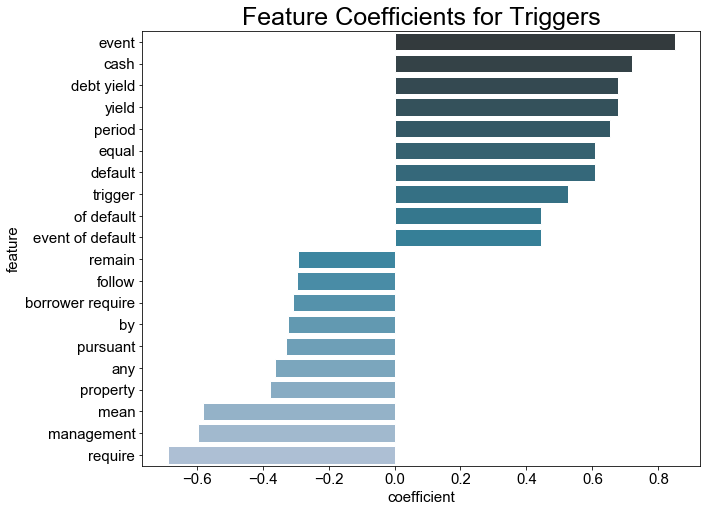

In [76]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for Triggers', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [77]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [78]:
# Checking our predictions
preds[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [79]:
## Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

This is a confusion matrix for our test data vs predictions:
[[904  36]
 [379 742]]


In [80]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [81]:
cm_test

,Predicted Negative,Predicted Positive
Actual Negative,904,36
Actual Positive,379,742


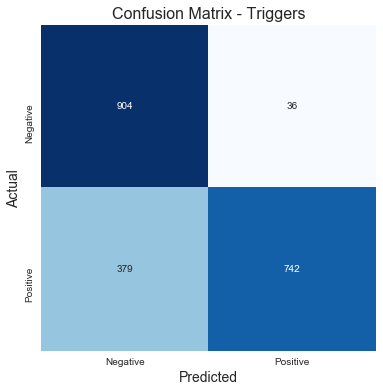

In [82]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title(f'Confusion Matrix - Triggers', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [83]:
# Setting up probabilities for the ROC curve
#pred_proba = results_cvec.predict_proba(X_test)
#preds = results_cvec.predict(X_test)



In [84]:
# Calculate probabilities
pred_proba = [i[1] for i in results_cvec.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df.shape

(2061, 2)

In [85]:
# We establish the probabilities to be used to create the ROC curve
y_pred_proba = results_cvec.predict_proba(X_test)

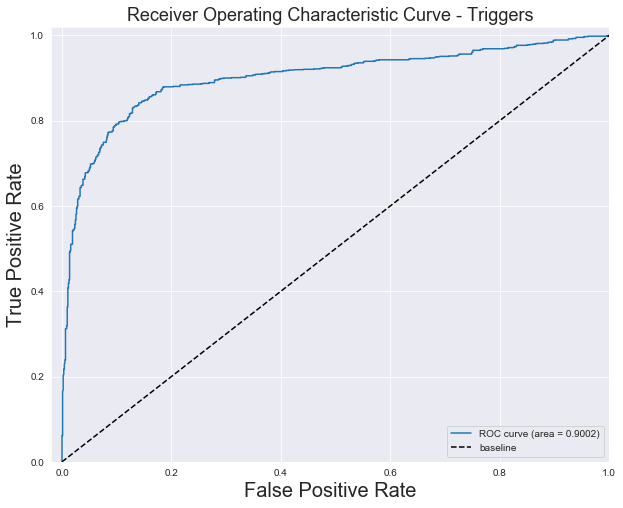

In [86]:
fpr, tpr, _= roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title(f'Receiver Operating Characteristic Curve - Triggers', fontsize=18)
plt.legend(loc="lower right");

In [87]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [88]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(test_index),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

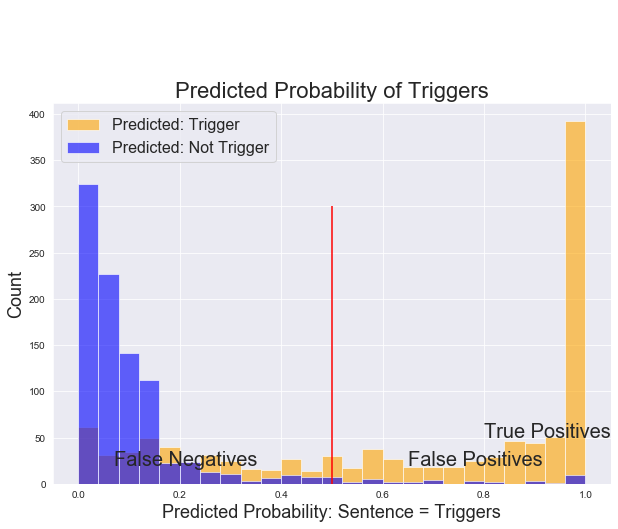

In [89]:
# Histogram overlay for two classes
plt.figure(figsize = (10,7))

# Create two histograms of observations.

plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = f'Predicted: Trigger')
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = f'Predicted: Not Trigger')


plt.vlines(x = .5,
           ymin = 0,
           ymax = 300,
           color = 'r',
           linestyle = '-')


# Label axes.
plt.title(f'Predicted Probability of Triggers', fontsize = 22)
plt.ylabel('Count', fontsize = 18)
plt.xlabel(f'Predicted Probability: Sentence = Triggers', fontsize = 18)

plt.annotate(xy = (0.05, 500), s = 'True Negatives', size = 20)
plt.annotate(xy = (0.07, 20), s = 'False Negatives', size = 20)
plt.annotate(xy = (0.65, 20), s = 'False Positives', size = 20)
plt.annotate(xy = (0.8, 50), s = 'True Positives', size = 20)

# Create legend.
plt.legend(fontsize = 16);

In [90]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

,prediction,actual,model_input
index,,,
0,1,1,on each business day the financial institution maintain the block account which be u s bank national association as of the origination date be require to remit all fund on deposit in the block account a if no trigger period or event of default under the mortgage loan be continue to the borrower and b during a trigger period or while an event of default under the mortgage loan be continue to the cash management account
1,1,1,the borrower have establish and be require to maintain a cash management account the cash management account at the cash management bank into which income from the property other than certain de minimis non core and sponsorship income be require to be deposit during any period that the aggregate debt service coverage ratio base on net operating income as calculate under the loan documents for the trail 12 month period as of the most recent fiscal quarter and annualiz debt service include any schedule amortization fall below 1 30x as of the end of any fiscal quarter until such debt service coverage ratio exceed 1 30x as of the end of the trail 12 month period for two consecutive fiscal quarter such period a trigger period or while an event of default under the mortgage loan be continue
2,1,1,during a trigger period or while an event of default under the mortgage loan be continue all amount available in the cash management account will be apply on each loan payment date in the follow order of priority i to the tax and insurance reserve account a 1 12th of project annual tax and b 1 12th of project annual insurance premium unless certain blanket policy be in effect ii to the lender the amount of all schedule or delinquent interest and principal on the mortgage loan and all other amount then due and payable under the loan documents with amount in respect of principal pay last iii provide there have be no enforcement action after the occurrence and during the continuance of an event of default under the mortgage loan to operating account an amount equal to the budget operating expense for the month in which such loan payment date occur as describe in description of the mortgage loan cash management iv to the capital expenditure reserve account an amount equal to the less of a 9 018 which be 0 15 per own rentable square foot per annum or b the amount that would because the total amount contain in the capital expenditure reserve account to equal 108 216 which be 12 time the monthly require amount set forth in clause a v to the ti lc reserve account an amount equal to the less of a 60 120 which be 1 00 per own rentable square foot per annum or b the amount that would because the total amount contain in the capital expenditure reserve account to equal 721 438 which be 12 time the monthly require amount set forth in clause a and vi unless an event of default under the loan documents be continue all remain amount to the borrower
3,1,1,on any business day all amount on deposit in the cash management account in excess of the amount of required reserve and all other amount due and payable on the next loan payment date will be release to the borrower unless an event of default under the mortgage loan have occur and be continue
4,1,1,available fund in each cash management account be require to be sweep into either the operating accounts or upon the commencement of a trigger period or event of default the cash management account at the end of each business day


In [91]:
misclassified = results[results['prediction'] != results['actual']]


In [92]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [93]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff', 'delayed_repayment']]

In [94]:
misclassified.head()

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,...,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
index,,,,,,,,,,,,,,,,,,,,,
19,0,1,except during a cash management period fund in the lockbox account be require to be disburse to the borrowers on a daily basis,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"Except during a Cash Management Period, funds in the Lockbox Account are required to be disbursed to the Borrowers on a daily basis.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20,0,1,during the continuance of any cash management period fund in the lockbox account be require to be sweep into a cash management account under the sole dominion and control of the lender,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"During the continuance of any Cash Management Period, funds in the Lockbox Account are required to be swept into a Cash Management Account under the sole dominion and control of the Lender.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22,0,1,after the occurrence and during the continuance of any event of default under the whole loan amount in the cash management account may be apply by lender in PRON sole discretion,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"After the occurrence and during the continuance of any event of default under the Whole Loan, amounts in the Cash Management Account may be applied by Lender in its sole discretion.",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,1,no reserve account be fund by the borrowers at origination however monthly deposit to certain reserve account will be require during the continuance of a cash management period or upon the borrower s receipt of certain lease termination fee,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"No reserve accounts were funded by the Borrowers at origination; however, monthly deposits to certain reserve accounts will be required during the continuance of a Cash Management Period or upon the BorrowerÕs receipt of certain lease termination fees.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28,0,1,unless a cash management period have occur and be continue available fund in the lockbox account be require to be sweep daily into a borrower control operating account,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"Unless a Cash Management Period has occurred and is continuing, available funds in the Lockbox Account are required to be swept daily into a Borrower-controlled operating account.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
full_test_set = filtered.drop(['Document', 'Sentence', 'Total', 'istrigger', 'SentenceTokens', 'SentenceLemmas'], axis = 1).sum(axis = 0).to_frame()
full_test_set

,0
loan_default,499.0
aggregate_dscr_fall,7.0
dscr_fall,13.0
unspecified,485.0
debt_yield_fall,167.0
aggregate_debt_yield_fall,8.0
mezzanine_default,57.0
tenant_failure,64.0
mezzanine_outstanding,7.0
operator_termination,7.0


In [96]:
# Check how many of each in the data set
misclassified_test_set = misclassified.drop(['prediction', 'actual', 'Document', 'Sentence', 'model_input'], axis=1).sum(axis=0).to_frame()
misclassified_test_set

,0
loan_default,48.0
aggregate_dscr_fall,0.0
dscr_fall,0.0
unspecified,312.0
debt_yield_fall,8.0
aggregate_debt_yield_fall,0.0
mezzanine_default,0.0
tenant_failure,7.0
mezzanine_outstanding,2.0
operator_termination,0.0


In [97]:
misclassified_results = full_test_set.merge(misclassified_test_set, left_index = True, right_index = True)
misclassified_results.rename(columns = {'0_x': 'full_test_set', '0_y': 'num_misclassified'}, inplace = True)
misclassified_results['percent_misclassified'] = 100 * misclassified_results['num_misclassified'] / misclassified_results['full_test_set']
misclassified_results['percent_misclassified'] = misclassified_results['percent_misclassified'].round(1)
misclassified_results = misclassified_results.merge(in_train_set, left_index = True, right_index = True)
misclassified_results.rename(columns = {0: 'in_train_set'}, inplace = True)
misclassified_results['in_train_set'] = misclassified_results['in_train_set'].map({True: 'yes', False: 'no'})
misclassified_results

,full_test_set,num_misclassified,percent_misclassified,in_train_set
loan_default,499.0,48.0,9.6,yes
aggregate_dscr_fall,7.0,0.0,0.0,no
dscr_fall,13.0,0.0,0.0,yes
debt_yield_fall,167.0,8.0,4.8,yes
aggregate_debt_yield_fall,8.0,0.0,0.0,yes
mezzanine_default,57.0,0.0,0.0,yes
tenant_failure,64.0,7.0,10.9,yes
mezzanine_outstanding,7.0,2.0,28.6,no
operator_termination,7.0,0.0,0.0,yes
bankruptcy,44.0,3.0,6.8,no


In [98]:
filtered.head()

,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,...,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment,Total,istrigger,SentenceTokens,SentenceLemmas
0,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"On each Business Day, the financial institution maintaining the blocked account (which was U.S. Bank National Association as of the Origination Date) is required to remit all funds on deposit in the blocked account (a) if no Trigger Period or event of default under the Mortgage Loan is continuing, to the Borrower and (b) during a Trigger Period or while an event of default under the Mortgage Loan is continuing, to the Cash Management Account.",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.0,1,"On each Business Day , the financial institution maintaining the blocked account ( which was U.S. Bank National Association as of the Origination Date ) is required to remit all funds on deposit in the blocked account ( a ) if no Trigger Period or event of default under the Mortgage Loan is continuing , to the Borrower and ( b ) during a Trigger Period or while an event of default under the Mortgage Loan is continuing , to the Cash Management Account .",on each business day the financial institution maintain the block account which be u s bank national association as of the origination date be require to remit all fund on deposit in the block account a if no trigger period or event of default under the mortgage loan be continue to the borrower and b during a trigger period or while an event of default under the mortgage loan be continue to the cash management account
1,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"The Borrower has established and is required to maintain a cash management account (the ÒCash Management AccountÓ) at the Cash Management Bank into which income from the Property (other than certain de minimis non-core and sponsorship income) is required to be deposited during any period that the aggregate debt service coverage ratio (based on net operating income, as calculated under the Loan Documents) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service (including any scheduled amortization), falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters (such period a ÒTrigger PeriodÓ), or while an event of default under the Mortgage Loan is continuing.",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2.0,1,"The Borrower has established and is required to maintain a cash management account ( the ÒCash Management AccountÓ ) at the Cash Management Bank into which income from the Property ( other than certain de minimis non - core and sponsorship income ) is required to be deposited during any period that the aggregate debt service coverage ratio ( based on net operating income , as calculated under the Loan Documents ) for the trailing 12-month period as of the most recent fiscal quarter and annualized debt service ( including any scheduled amortization ) , falls below 1.30x as of the end of any fiscal quarter until such debt service coverage ratio exceeds 1.30x as of the end of the trailing 12-month period for two consecutive fiscal quarters ( such period a ÒTrigger PeriodÓ ) , or while an event of default under the Mortgage Loan is continuing .",the borrower have establish and be require to maintain a cash management account the cash management account at the cash management bank into which income from the property other than certain de minimis non core and sponsorship income be require to be deposit during any period that the aggregate debt service coverage ratio base on net operating income as calculate under the loan documents for the trail 12 month period as of the most recent fiscal quarter and annualiz debt service include any schedule amortizatio

In [99]:
misclassified_test_set = misclassified[misclassified['nontrigger'] == 1]

In [100]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [101]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

We incorrectly predicted the trigger type for 415 sentences.


In [102]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

0    379
1     36
Name: prediction, dtype: int64

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [103]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,...,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
index,,,,,,,,,,,,,,,,,,,,,
757,1,0,dscr mean with respect to any 12 month period as of the last day of a fiscal quarter the ratio of i underwritten net operating income to ii the product of a twelve 12 time b the sum of the aggregate schedule principal and interest payment due and payable with respect to the mortgage loan on such date of determination if such date be a loan payment date or on the loan payment date immediately follow such date of determination if such date be not a loan payment date,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"ÒDSCRÓ means, with respect to any 12-month period as of the last day of a fiscal quarter, the ratio of (i) Underwritten Net Operating Income to (ii) the product of (A) twelve (12) times (B) the sum of the aggregate scheduled principal and interest payments due and payable with respect to the Mortgage Loan on such date of determination (if such date is a Loan Payment Date) or on the Loan Payment Date immediately following such date of determination (if such date is not a Loan Payment Date).",0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
758,1,0,underwritten net operating income mean with respect to any 12 month period end on the last day of a fiscal quarter x operate income for such 12 month period less normalized tenant improvement and leasing commission expenditure equal to 1 00 per square foot per annum and normalize capital improvement equal to 0 20 per square foot per annum minus y operating expense for such 12 month period quarter,20120828_01Y0R8_Prospectus_CM000000002058750876.pdf,"ÒUnderwritten Net Operating IncomeÓ means, with respect to any 12-month period ending on the last day of a fiscal quarter, (x) Operating Income for such 12-month period (less normalized tenant improvement and leasing commission expenditures equal to 1.00 per square foot per annum and normalized capital improvements equal to 0.20 per square foot per annum) minus (y) Operating Expenses for such 12-month period quarter.",0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
828,1,0,a ground rent reserve period will occur in the event that i neither a marriott management period nor a period during which a qualified replacement hotel operator be manage the property be continue or ii a marriott management period or a period during which a qualified replacement hotel operator be manage the property be continue but the hotel operator be not require to pay ground rent directly to the ground lessor pursuant to the term of the hotel operating agreement,20160510_02B0XU_Prospectus_SD000000002312723382.pdf,A ÒGround Rent Reserve PeriodÓ will occur in the event that (i) neither a Marriott Management Period nor a period during which a Qualified Replacement Hotel Operator is managing the Property is continuing or (ii) a Marriott Management Period or a period during which a Qualified Replacement Hotel Operator is managing the Property is continuing but the Hotel Operator is not required to pay Ground Rent directly to the Ground Lessor pursuant to the terms of the Hotel Operating Agreement.,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
829,1,0,dscr mean as of any date the ratio of i net operating income less any contribution to the ff e reserve require under the hotel operating agreement and the ff e reserve account for the 12 month period end with the most recently complete calendar month to ii the sum of a the schedule principal and interest payment due under the note with respect to such period and b the aggregate of the mezzanine monthly debt service amount with respect to such period,20160510_02B0XU_Prospectus_SD000000002312723382.pdf,"ÒDSCRÓ means, as of any date, the ratio of (i) Net Operating Income (less any contributions to the FF&E reserve required under the Hotel Operating Agr

In [104]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [105]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

36 sentences were predicted to be the trigger category, but in fact were not this category.


In [106]:
misclassified_as_true_summary.loc['sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [107]:
misclassified_as_true_summary

,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
757,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
758,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
828,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
829,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
877,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
910,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
958,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1033,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1042,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Misclassifications: wrongly predicted NOT to be the trigger category

In [108]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

,prediction,actual,model_input,Document,Sentence,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,...,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff,delayed_repayment
index,,,,,,,,,,,,,,,,,,,,,
19,0,1,except during a cash management period fund in the lockbox account be require to be disburse to the borrowers on a daily basis,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"Except during a Cash Management Period, funds in the Lockbox Account are required to be disbursed to the Borrowers on a daily basis.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20,0,1,during the continuance of any cash management period fund in the lockbox account be require to be sweep into a cash management account under the sole dominion and control of the lender,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"During the continuance of any Cash Management Period, funds in the Lockbox Account are required to be swept into a Cash Management Account under the sole dominion and control of the Lender.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22,0,1,after the occurrence and during the continuance of any event of default under the whole loan amount in the cash management account may be apply by lender in PRON sole discretion,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"After the occurrence and during the continuance of any event of default under the Whole Loan, amounts in the Cash Management Account may be applied by Lender in its sole discretion.",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,1,no reserve account be fund by the borrowers at origination however monthly deposit to certain reserve account will be require during the continuance of a cash management period or upon the borrower s receipt of certain lease termination fee,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"No reserve accounts were funded by the Borrowers at origination; however, monthly deposits to certain reserve accounts will be required during the continuance of a Cash Management Period or upon the BorrowerÕs receipt of certain lease termination fees.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28,0,1,unless a cash management period have occur and be continue available fund in the lockbox account be require to be sweep daily into a borrower control operating account,20150307_028S2X_Prospectus_SD000000002389024187.pdf,"Unless a Cash Management Period has occurred and is continuing, available funds in the Lockbox Account are required to be swept daily into a Borrower-controlled operating account.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,0,1,extraordinary expense mean during the continuance of a cash management period an extraordinary operate expense or capital expenditure not set forth in the approved annual budget,20190226_02IY6Y_Prospectus_SD000000002591071244.pdf,"ÒExtraordinary ExpenseÓ means, during the continuance of a Cash Management Period, an extraordinary operating expense or capital expenditure not set forth in the Approved Annual Budget.",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2233,0,1,the borrower be also require to fund an excess cash flow reserve during a cash management period in an amount equal to all cash in excess of debt service on the whole loan and the mezzanine loans required reserve and certain other operating expense and in certain case require distribution for tax payment and similar matter,20190226_02IY6Y_Prospectus_SD000000002591071244.pdf,"The Borrowers are also required to fund an excess cash flow reserve during a Cash Management Period in an amount equal to all cash in excess of debt service on the Whole Loan and the Mezzanine Loans, required reserves and certain other operating expenses (and in certain cases, required distributions for tax payments and similar matters).",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2235,0,1,during a cash management period all amount in the clearing accoun

In [109]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger', 'sff']]


In [110]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

379 sentences were predicted not to be the trigger category, but in fact were this trigger category.


In [111]:
misclassified_as_false_summary.loc['sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,prediction,actual,loan_default,aggregate_dscr_fall,dscr_fall,unspecified,debt_yield_fall,aggregate_debt_yield_fall,mezzanine_default,tenant_failure,mezzanine_outstanding,operator_termination,bankruptcy,sponsor_termination,renovations,nontrigger,sff
index,,,,,,,,,,,,,,,,,
19,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
20,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
22,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
28,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2235,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2236,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [112]:
misclassified_as_false['model_input_nopunc'] = misclassified_as_false['model_input'].str.replace("[^a-zA-Z0-9#']", " ").str.replace('\s{2,}', ' ')

missed_triggers_lemmas = ' '.join(misclassified_as_false['model_input_nopunc'])
missed_triggers_lemmas[:75]


/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


'except during a cash management period fund in the lockbox account be requi'

In [113]:
missed_triggers_lemmas_list = [lemma for lemma in missed_triggers_lemmas.split(' ') if lemma not in stopwords]
# missed_triggers_lemmas_list = [lemma for lemma in missed_triggers_lemmas_list if lemma not in stop_words]
missed_triggers_lemma_df = pd.Series(missed_triggers_lemmas_list)
missed_triggers_lemma_df.head()
#missed_triggers_lemma_df['model_input'] = missed_triggers_lemma_df['model_input'].str.replace("[^a-zA-Z0-9#']", " ")

0          cash
1    management
2        period
3          fund
4       lockbox
dtype: object

In [114]:
missed_triggers_lemma_df.value_counts().sort_values(ascending = False).head(10)

account       787
cash          587
deposit       515
mortgage      512
require       431
management    407
reserve       401
              397
lender        396
fund          383
dtype: int64

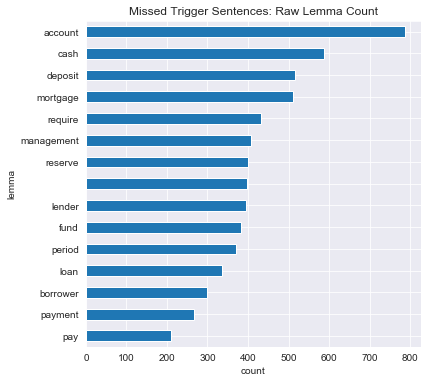

In [115]:
# Plotting the raw lemma count
lemma_series = missed_triggers_lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Missed Trigger Sentences: Raw Lemma Count');

### Export Misclassification summaries

In [116]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_false_06_15_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/exported_data/{target}_misclassified_as_true_06_15_20.csv')

In [117]:
# Export to CSV file
# misclassified_as_false.to_csv(f'../data/exported_data/{target}_misclassified_as_false_sentences_06_15_20.csv')
# misclassified_as_true.to_csv(f'../data/exported_data/{target}_misclassified_as_true_sentences_06_15_20.csv')